In [1]:
import os.path

import scanpy as sc
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.sc.utils import adapt_source_population_size, compute_optimal_transport
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
import networkx as nx
import ot
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# sc.set_figure_params(figsize=(16, 8))
set_seed(0)

In [2]:
use_magic = False
normalize_per_cell = True
normalize_gene_std = False
use_log1p = True

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                     "datasets/Sciplex3/processed/SrivatsanTrapnell2020_sciplex3_with_grn.h5ad")
                    )

In [4]:
pert_accuracies_dict = np.load(os.path.join(get_project_root(), 
                                            "datasets/Sciplex3/processed/pert_accuracies_dict.npy"),
                              allow_pickle=True).item()

In [5]:
adata

AnnData object with n_obs × n_vars = 25581 × 13298
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'
    varp: 'grn_adj_mat'

In [6]:
adata.layers["counts"] = adata.X

In [7]:
adata.var["gene_name"] = adata.var.index

In [8]:
adata

AnnData object with n_obs × n_vars = 25581 × 13298
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name'
    layers: 'counts'
    varp: 'grn_adj_mat'

## Add Morgan Fingerprints

In [9]:
all_chembl_ids = list(adata.obs['chembl-ID'].unique())

In [10]:
single_chembl_ids = []
for chembl_id in all_chembl_ids:
    if isinstance(chembl_id, str) and chembl_id.startswith("CHEMBL"):
        splitted_id = chembl_id.split(";")
        for single_chembl_id in splitted_id:
            single_chembl_ids.append(single_chembl_id)
        

In [11]:
len(single_chembl_ids)

166

We submited the list single_chembl_ids on the ChEMBL interface and retrieved a csv file with various information about the drugs, including their Smiles.

In [12]:
ChEMBL_to_smiles_sciplex = pd.read_csv(os.path.join(get_project_root(), 
                                                    "datasets/Sciplex3/ChEMBL_to_smiles_sciplex.csv"),
            sep=";")

In [13]:
ChEMBL_to_smiles_sciplex["Fingerprint"] = ChEMBL_to_smiles_sciplex["Smiles"].apply(
    lambda s: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(str(s)), 
                                                    radius=2, 
                                                    nBits=1024) if  isinstance(s, str) else None
                                               )

In [14]:
ChEMBL_to_smiles_sciplex = ChEMBL_to_smiles_sciplex[ChEMBL_to_smiles_sciplex["Fingerprint"].apply(
    lambda x: x is not None)]

In [15]:
ChEMBL_to_morgan_fp_dict = {ChEMBL_to_smiles_sciplex.iloc[i]["ChEMBL ID"]: 
                            np.array(ChEMBL_to_smiles_sciplex.iloc[i]["Fingerprint"])
                            for i in range(len(ChEMBL_to_smiles_sciplex))}

In [16]:
adata.uns["ChEMBL_to_morgan_fp_dict"] = ChEMBL_to_morgan_fp_dict

## Highly variable genes

In [17]:
sc.pp.filter_genes(adata, min_counts=1)

if normalize_per_cell:
    sc.pp.normalize_per_cell(adata, key_n_counts='ncounts')

# Find highly variable genes
if not use_log1p:
    adata_copy = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

    adata.var['highly_variable'] = adata_copy.var['highly_variable']
    
else:
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='cell_ranger')

In [18]:
adata = adata[:, adata.var['highly_variable']].copy()

In [19]:
adata.obs.reset_index(inplace=True)

In [20]:
adata

AnnData object with n_obs × n_vars = 25581 × 4000
    obs: 'cell_barcode', 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ChEMBL_to_morgan_fp_dict', 'log1p', 'hvg'
    layers: 'counts'
    varp: 'grn_adj_mat'

In [21]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

## Compute Umap

In [22]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)

In [23]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=50)

In [24]:
sc.tl.umap(adata,  maxiter=600)

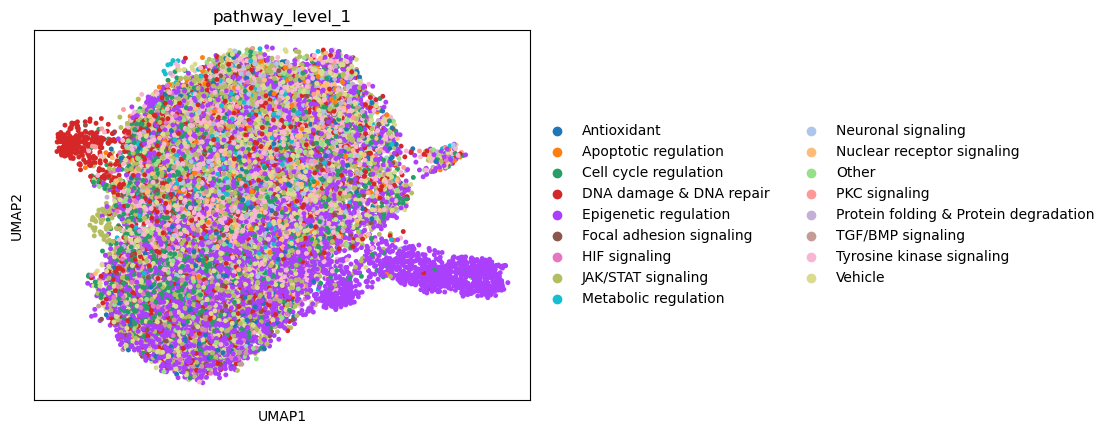

In [25]:
sc.pl.umap(adata, color="pathway_level_1", size=50)

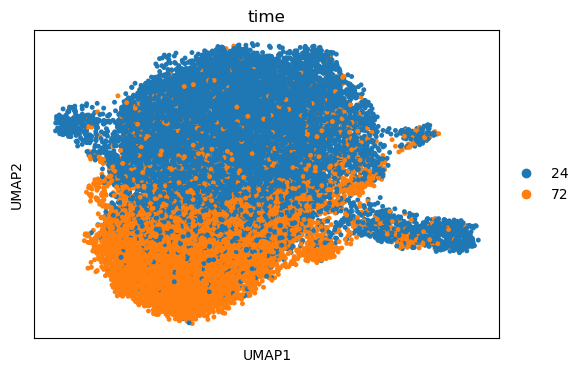

In [26]:
adata.obs["time"] = adata.obs["time"].astype("int")
adata.obs["time"] = adata.obs["time"].astype("category")
plt.rcParams["figure.figsize"] = (6, 4)
sc.pl.umap(adata, color="time", size=50)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


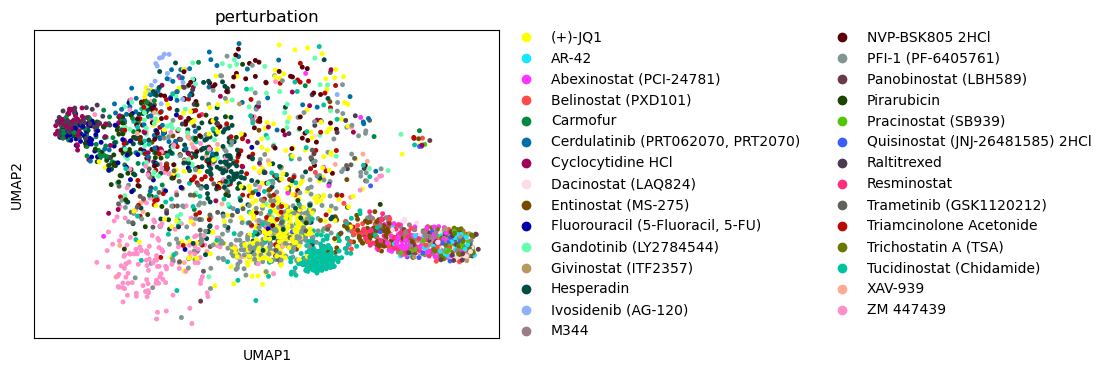

In [27]:
plt.rcParams["figure.figsize"] = (6, 4)
adata_subset = adata[adata.obs["perturbation"].apply(lambda p: pert_accuracies_dict[p]>0.8 if p!= "control" 
                                                     else False)].copy()
sc.pl.umap(adata_subset, color="perturbation", size=50)

In [28]:
cpt = 0
for p in pert_accuracies_dict:
    if pert_accuracies_dict[p]>0.7:
        if len(adata[adata.obs["perturbation"] == p].obs["time"].unique()) > 0:
            cpt += 1
            
print(cpt)

68


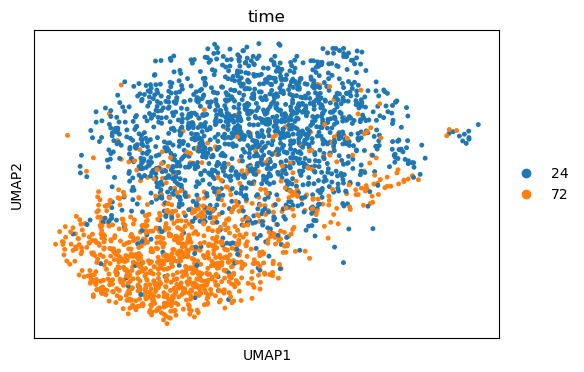

In [29]:
sc.pl.umap(adata[adata.obs["perturbation"] == "control"], color="time", size=50)

In [30]:
control_source = (adata.obs["perturbation"] == "control") & (adata.obs["time"] == 24.)
control_target = (adata.obs["perturbation"] == "control") & (adata.obs["time"] == 72.)

control_source_cells = adata[control_source].obs.index.tolist()
control_target_cells = adata[control_target].obs.index.tolist()

In [31]:
resampled_source_cells = adapt_source_population_size(control_source_cells, control_target_cells, shuffle=True)

In [32]:
ot_mapping = compute_optimal_transport(adata, resampled_source_cells, control_target_cells)

In [33]:
env_shortest_paths = {}
for match in ot_mapping.T:
    traj = [match[0], match[1]]
    env_shortest_paths[match[1]] = traj

In [34]:
# Convert keys to strings
obs_shortest_paths = {str(k): v for k, v in env_shortest_paths.items()}

adata.uns["obs_shortest_paths"] = obs_shortest_paths

In [35]:
for p in pert_accuracies_dict:
    if pert_accuracies_dict[p]>0.7:
        control_source = (adata.obs["perturbation"] == "control") & (adata.obs["time"] == 24.)
        perturbed_cells = (adata.obs["perturbation"] == p)
        
        if perturbed_cells.sum() > 50:  # We make sure there are at least 50 perturbed cells

            control_source_cells = adata[control_source].obs.index.tolist()
            control_target_cells = adata[perturbed_cells].obs.index.tolist()

            resampled_source_cells = adapt_source_population_size(control_source_cells, control_target_cells, shuffle=True)
            ot_mapping = compute_optimal_transport(adata, resampled_source_cells, control_target_cells)

            env_shortest_paths = {}
            for match in ot_mapping.T:
                traj = [match[0], match[1]]
                env_shortest_paths[match[1]] = traj

            # Convert keys to strings
            env_shortest_paths = {str(k): v for k, v in env_shortest_paths.items()}

            adata.uns[str(p) + "_shortest_paths"] = env_shortest_paths

## Final processing steps

In [36]:
# We apply the exact same processing to raw counts as for the Paul15 dataset
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_per_cell(adata)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 25581 cells and 4000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 292.56 seconds.
    Calculating affinities...
    Calculated affinities in 272.98 seconds.
  Calculated graph and diffusion operator in 571.37 seconds.
  Calculating imputation...
  Calculated imputation in 8.76 seconds.
Calculated MAGIC in 580.51 seconds.


In [38]:
adata

AnnData object with n_obs × n_vars = 25581 × 4000
    obs: 'cell_barcode', 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ChEMBL_to_morgan_fp_dict', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'pathway_level_1_colors', 'time_colors', 'obs_shortest_paths', 'Selisistat (EX 527)_shortest_paths', 'Ruxolitinib (INCB018424)_shortest_paths', '(+)-JQ1_shortest_paths', 'PFI-1 (PF-6405761)_shortest_paths', 'Tucidinostat (Chidamide)_shortest_paths', 'ITSA-1 (ITSA1)_shortest_paths', 'Roxadustat (FG-4592)_shortest_paths', 'Tazemetostat (EPZ-6438)_shortest_paths', 'SRT2104 (GSK2245840)_shorte

In [39]:
adata.write_h5ad(os.path.join(get_project_root(), 
                              "datasets/Sciplex3/processed/SrivatsanTrapnell2020_sciplex3_with_all_paths.h5ad")
            )

## Visualization

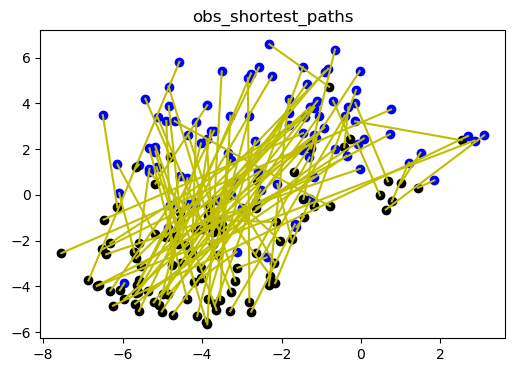

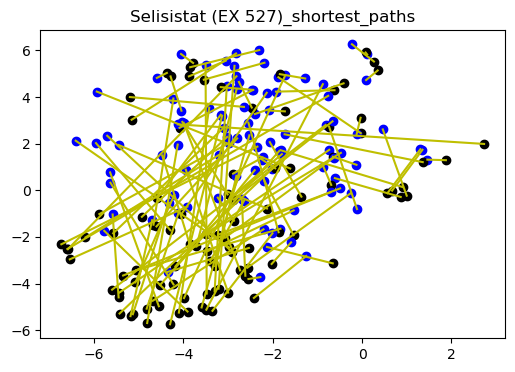

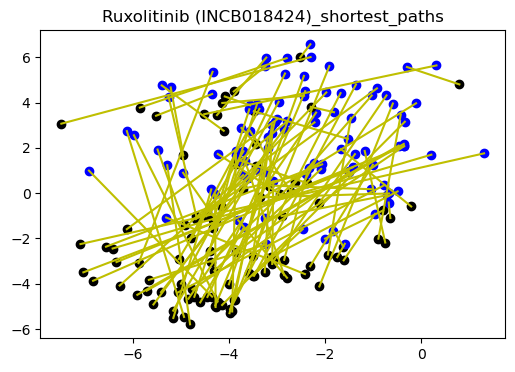

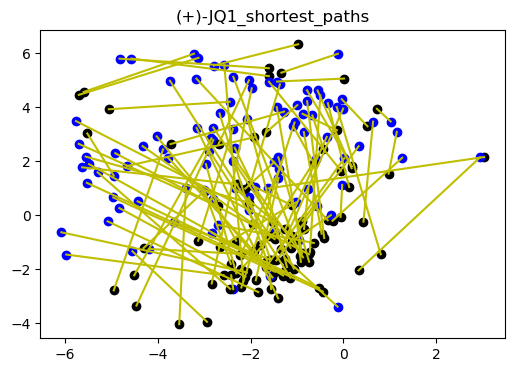

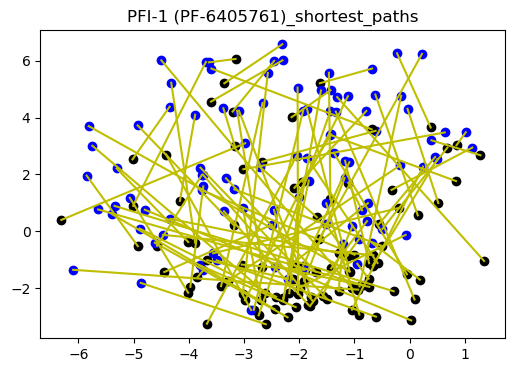

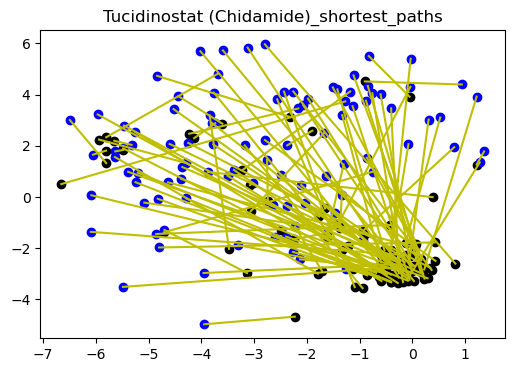

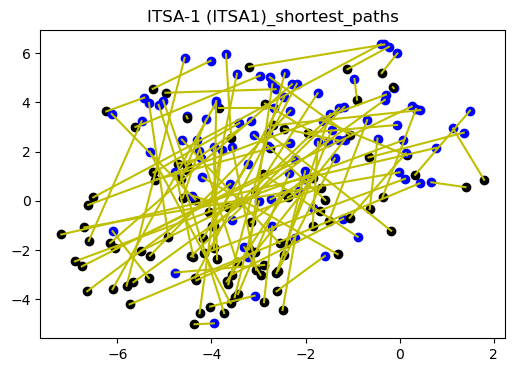

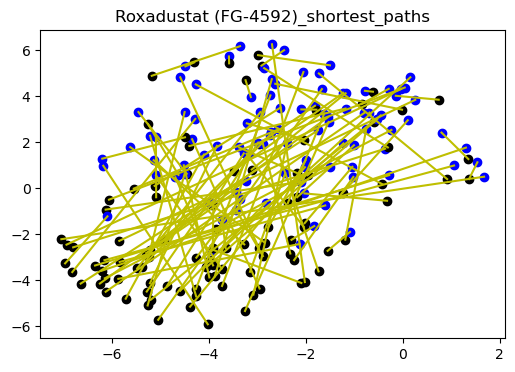

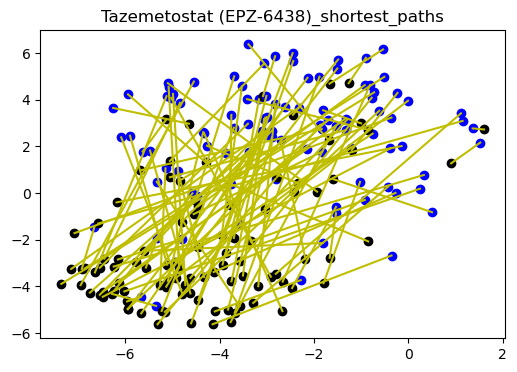

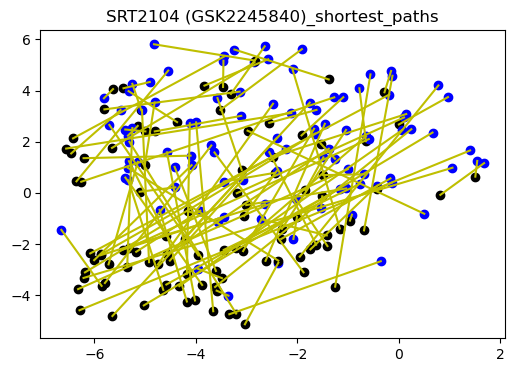

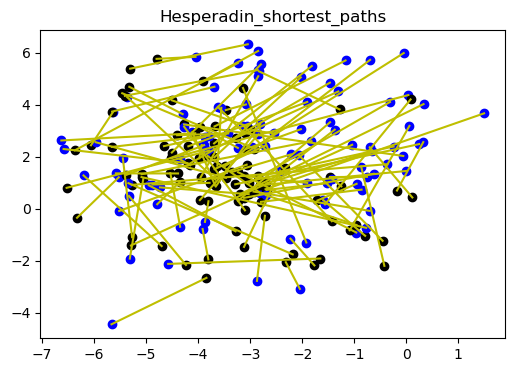

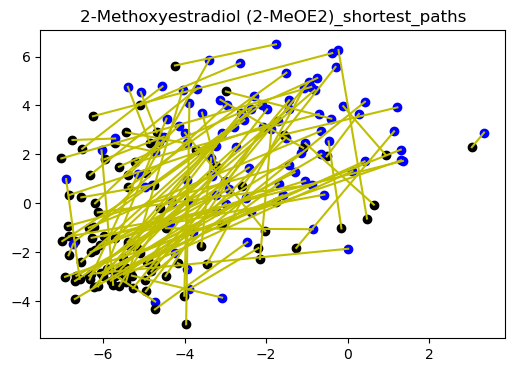

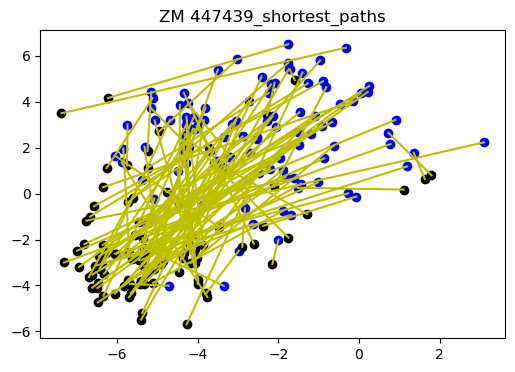

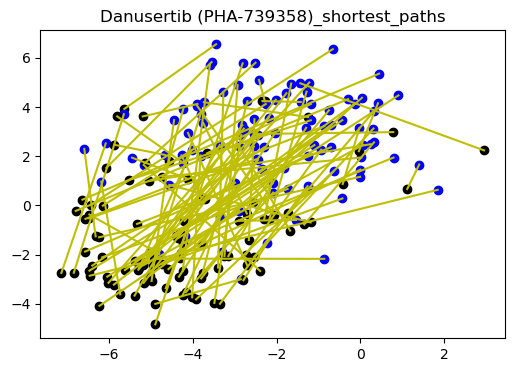

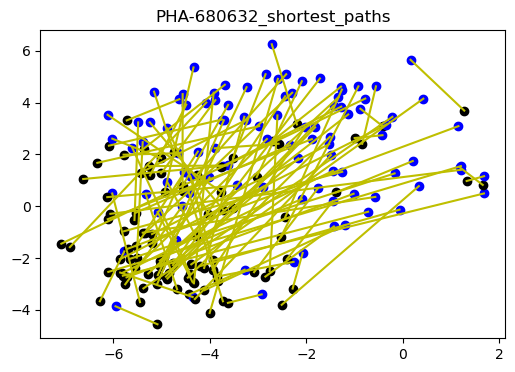

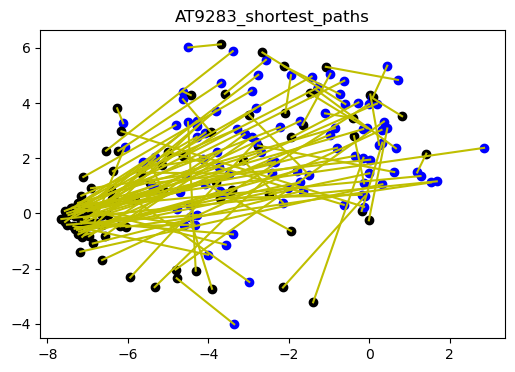

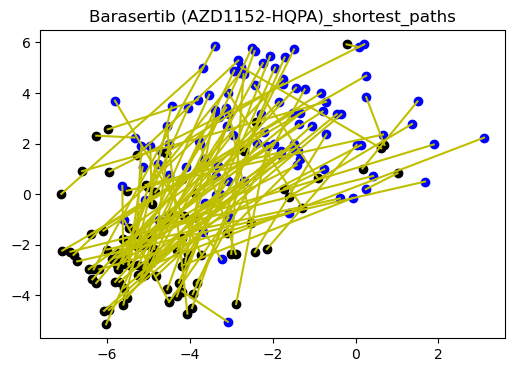

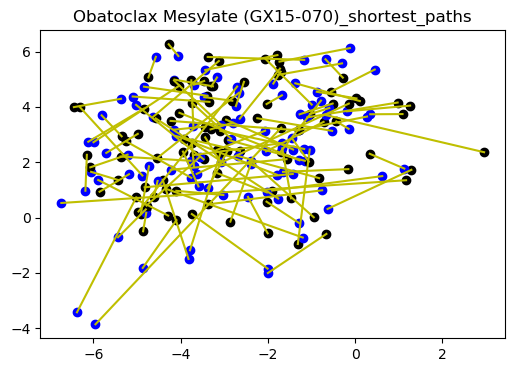

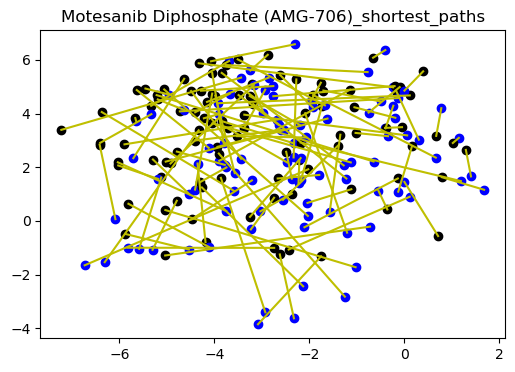

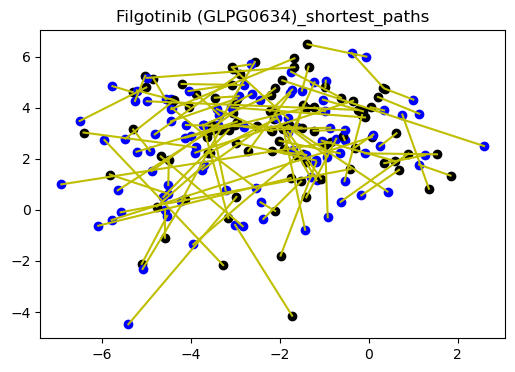

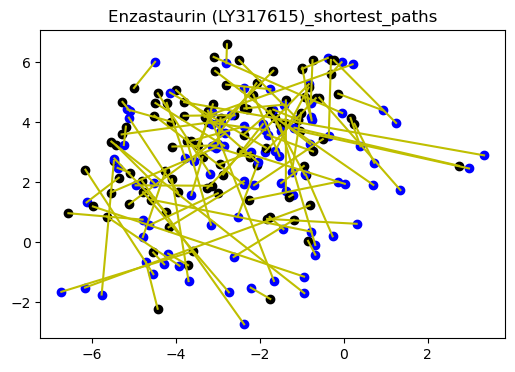

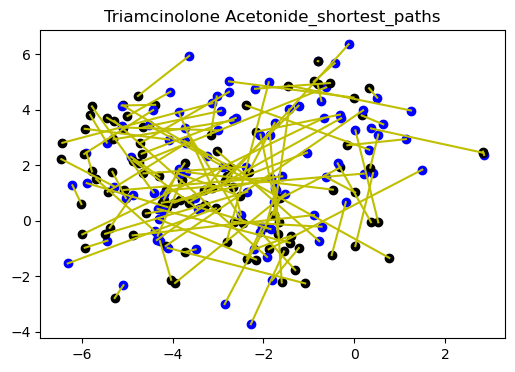

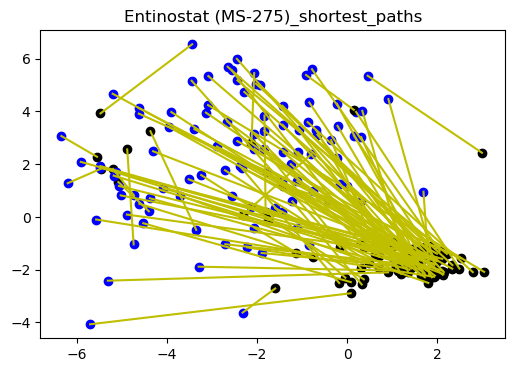

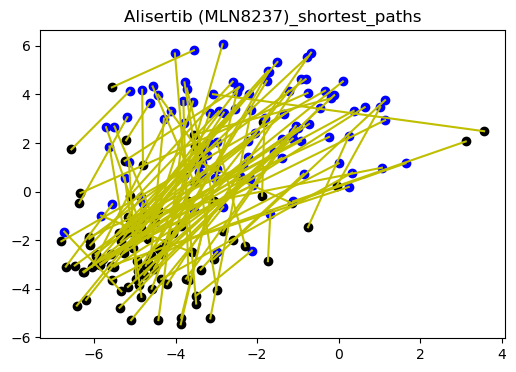

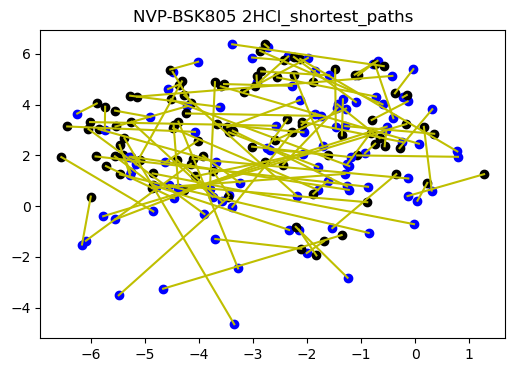

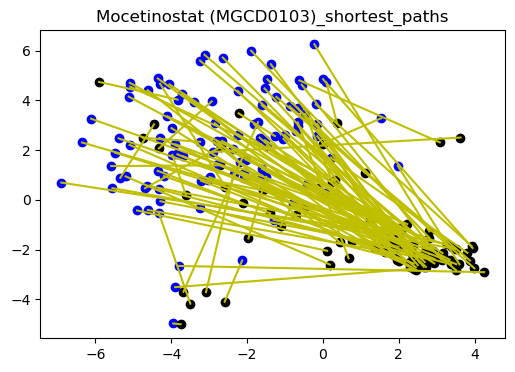

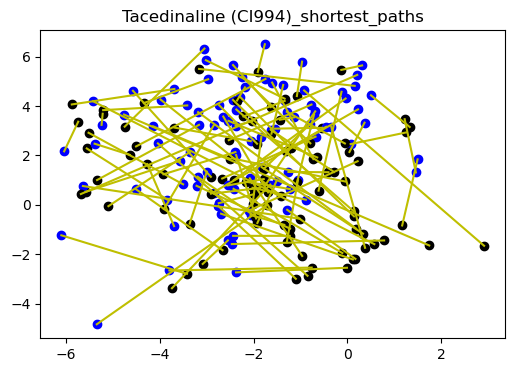

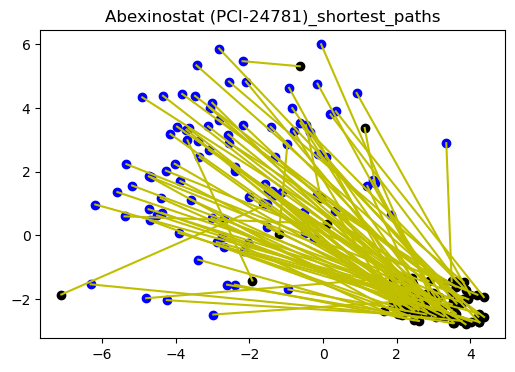

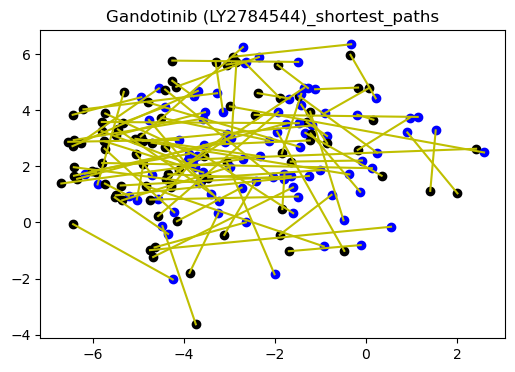

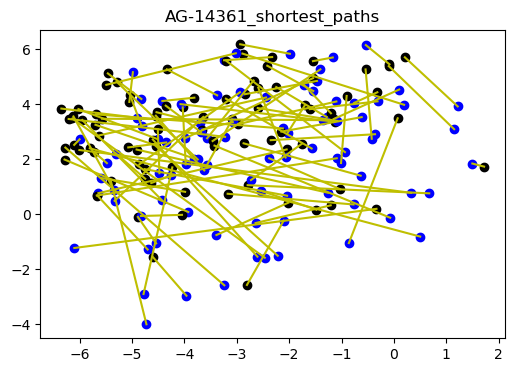

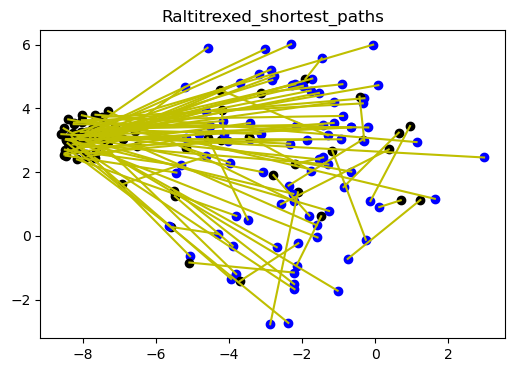

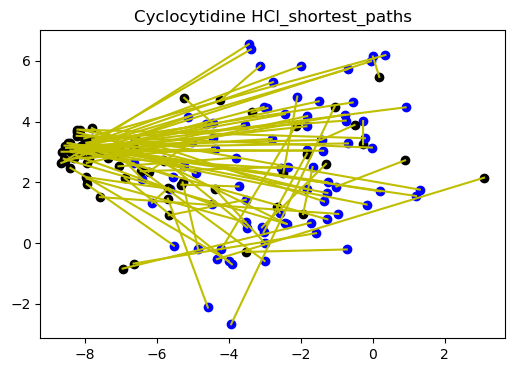

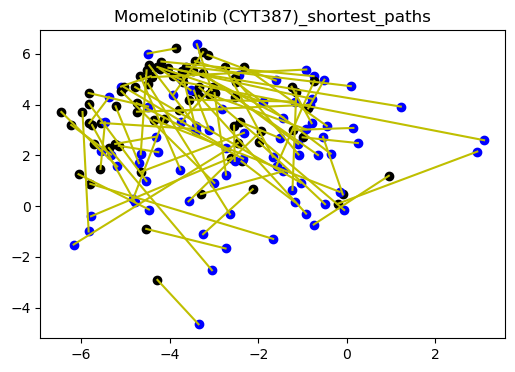

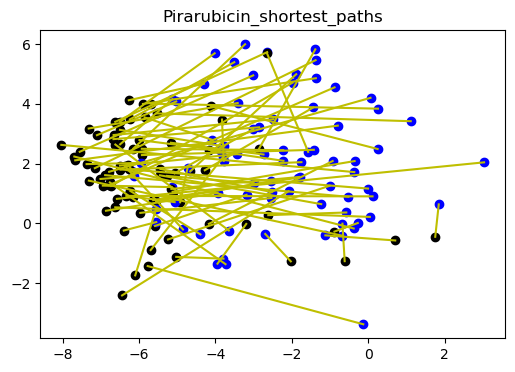

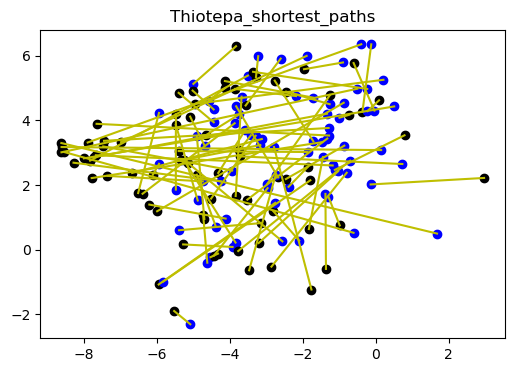

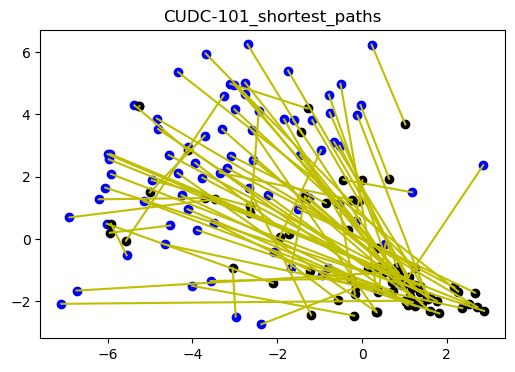

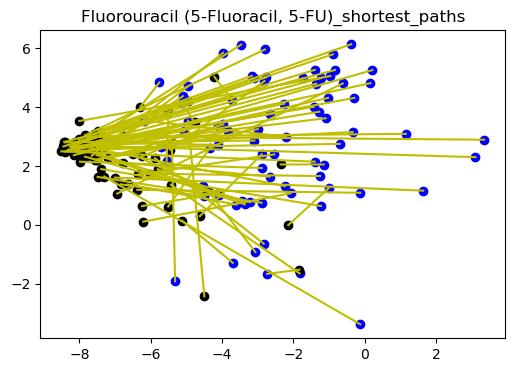

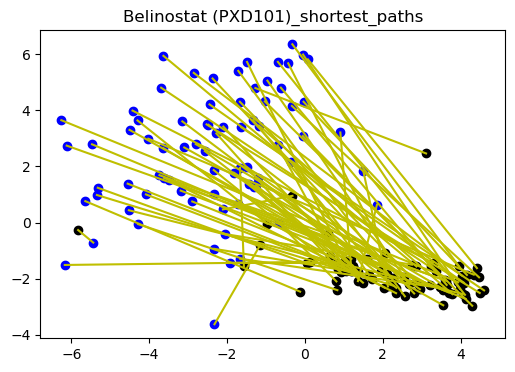

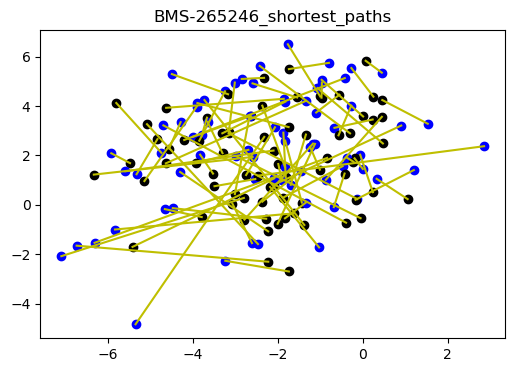

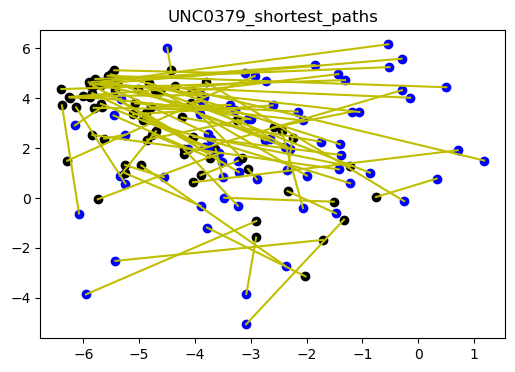

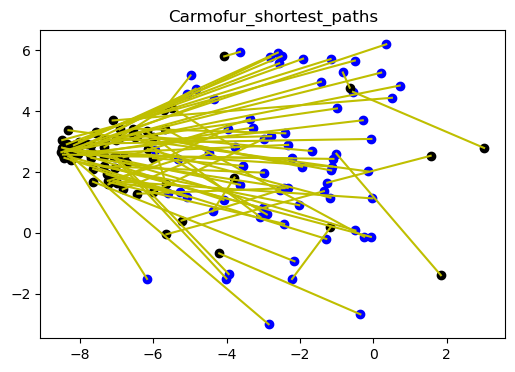

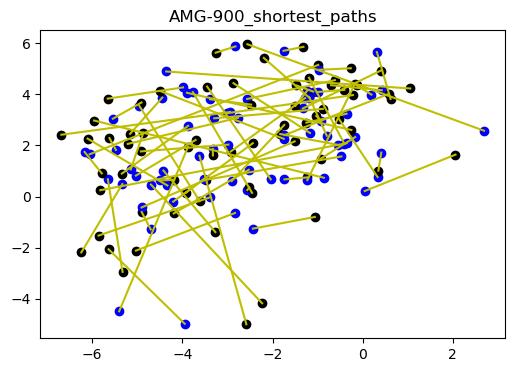

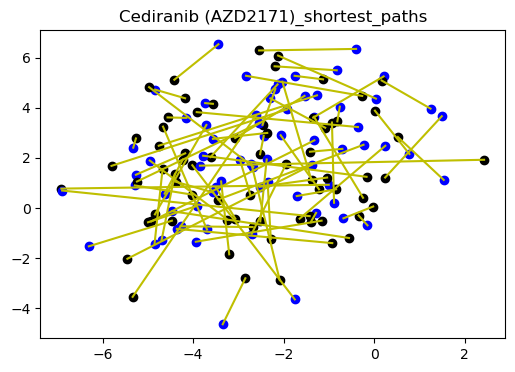

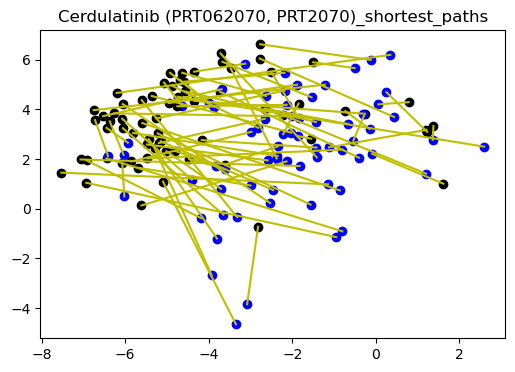

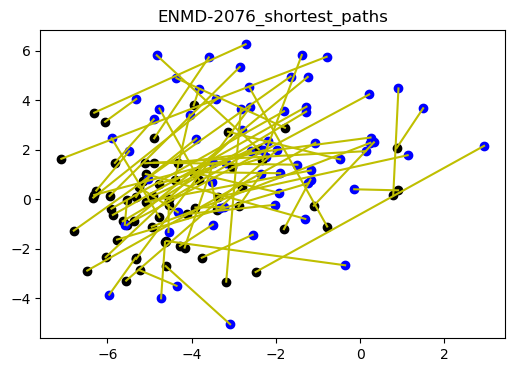

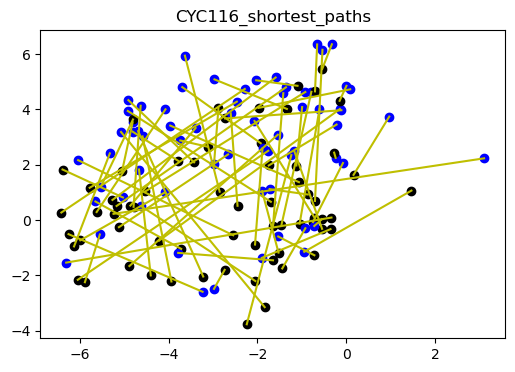

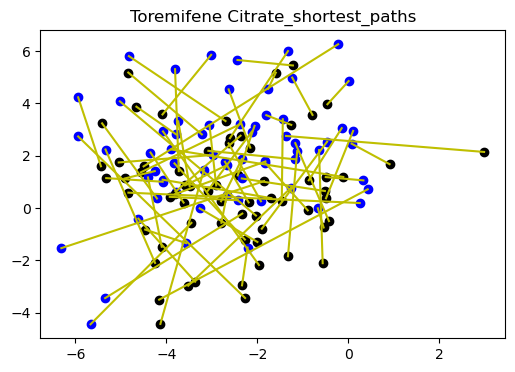

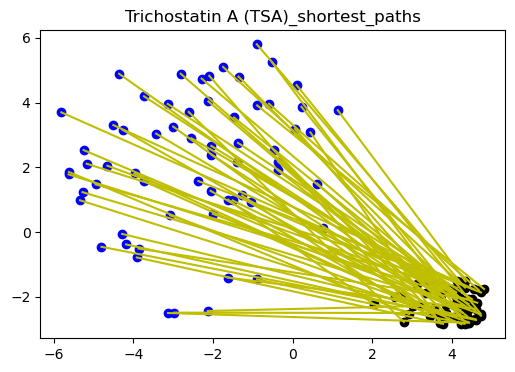

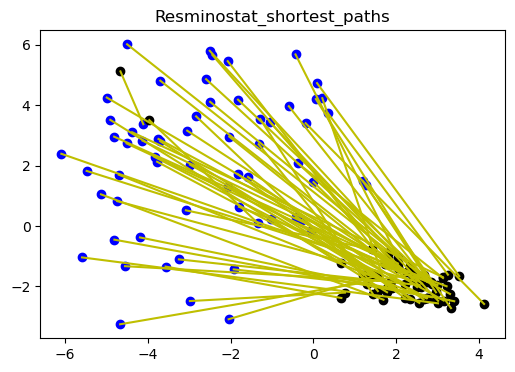

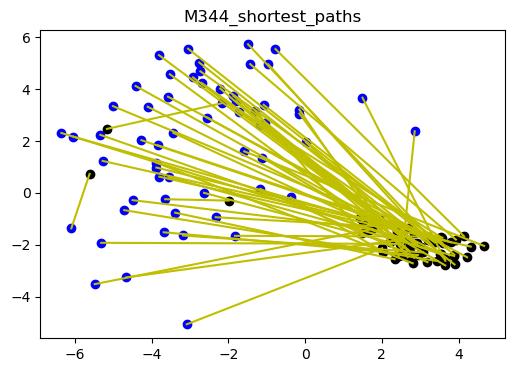

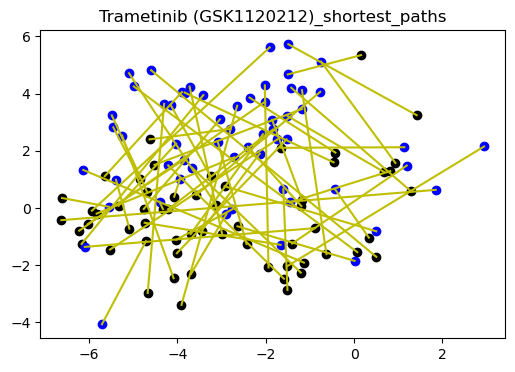

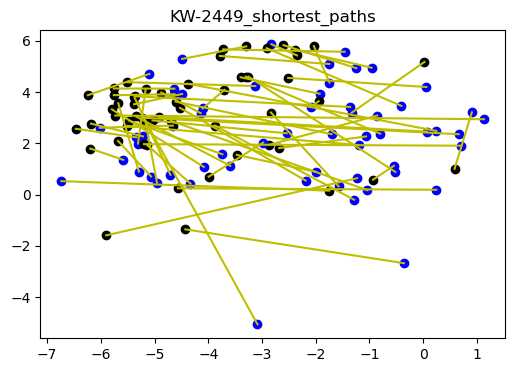

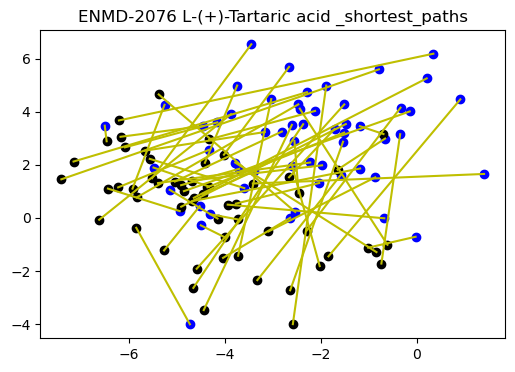

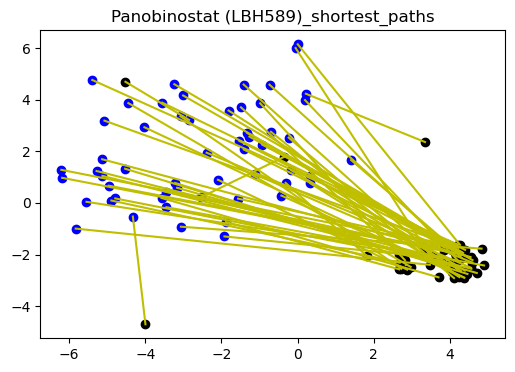

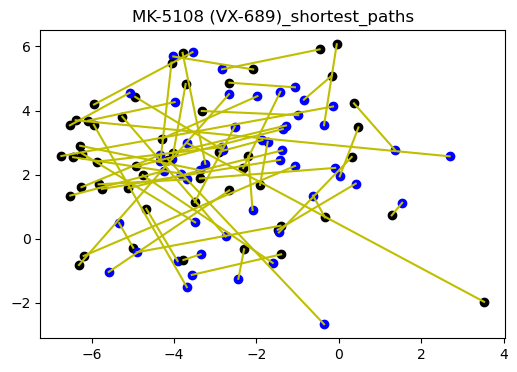

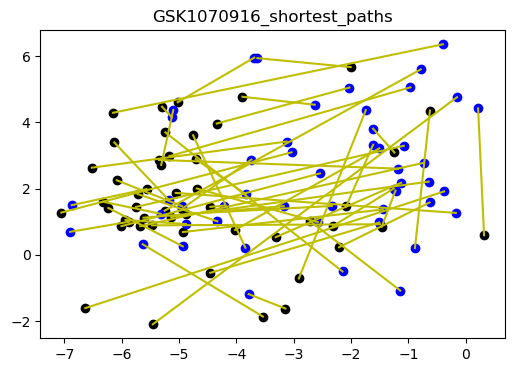

In [40]:
for k in adata.uns:
    if k.endswith("shortest_paths"):
        
        env_shortest_paths = adata.uns[k]

        cpt = 0
        for path in env_shortest_paths.values():
            cpt += 1

            if cpt > 100:
                break

            path_coord = adata.obsm["X_umap"][path]
            plt.plot(path_coord[:, 0], path_coord[:, 1], c="y")

            plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="b")
            plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

        plt.title(k)
        plt.show()
